In [3]:
%pip install torchmetrics

     ------------------------------------ 891.4/891.4 kB 910.3 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import mmap
import random
import pickle
import argparse
import matplotlib.pyplot as plt
from torchmetrics.classification import Accuracy

parser = argparse.ArgumentParser(description='This is a demonstration program')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 64
block_size = 256
max_iters = 100
learning_rate = 2e-5
eval_iters = 10
n_embd = 384
n_head = 4
n_layer = 16
dropout = 0.2
lr_scheduler_step_size = 1000

print(device)

cuda


In [2]:
chars = ""
with open("vocab.txt", 'r', encoding='utf-8') as f:
        text = f.read()
        chars = sorted(list(set(text)))
        
vocab_size = len(chars)

In [3]:
string_to_int = { ch:i for i,ch in enumerate(chars) }
int_to_string = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [string_to_int[c] for c in s]
decode = lambda l: ''.join([int_to_string[i] for i in l])

In [4]:
def get_random_chunk(split):
    filename = "train_split.txt" if split == 'train' else "val_split.txt"
    with open(filename, 'rb') as f:
        with mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ) as mm:
            file_size = len(mm)
            start_pos = random.randint(0, (file_size) - block_size*batch_size)
            mm.seek(start_pos)
            block = mm.read(block_size*batch_size-1)
            decoded_block = block.decode('utf-8', errors='ignore').replace('\r', '')
            data = torch.tensor(encode(decoded_block), dtype=torch.long)
            
    return data


def get_batch(split):
    data = get_random_chunk(split)
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [5]:
class Head(nn.Module):

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

# [1, 0, 0]
# [1, 0.6, 0]
# [1, 0.6, 0.4]
class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1) # (B, T, F) -> (B, T, [h1, h1, h1, h1, h2, h2, h2, h2, h3, h3, h3, h3])
        out = self.dropout(self.proj(out))
        return out
    

class FeedFoward(nn.Module):

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)
    
class Block(nn.Module):

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        y = self.sa(x)
        x = self.ln1(x + y)
        y = self.ffwd(x)
        x = self.ln2(x + y)
        return x
    
class GPTLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)
        
        
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, index, targets=None):
        B, T = index.shape
        tok_emb = self.token_embedding_table(index) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, index, max_new_tokens):
        for _ in range(max_new_tokens):
            index_cond = index[:, -block_size:]
            logits, loss = self.forward(index_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            index_next = torch.multinomial(probs, num_samples=1)
            index = torch.cat((index, index_next), dim=1)
        return index

model = GPTLanguageModel(vocab_size)
with open('model-01.pkl', 'rb') as f:
     model = pickle.load(f)
print('loaded successfully!')
m = model.to(device)



loaded successfully!


In [6]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [7]:
accuracy_metric = Accuracy(task="multiclass", num_classes=vocab_size).to(device)
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [8]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_scheduler_step_size, gamma=0.1)

In [23]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):
    if (iter % eval_iters == 0) or (iter==max_iters-1):
        losses = estimate_loss()
        print(f"step: {iter}, train loss: {losses['train']:.3f}, val loss: {losses['val']:.3f}")

    xb, yb = get_batch('train')

    logits, loss = model.forward(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
print(loss.item())

step: 0, train loss: 1.439, val loss: 1.440
step: 10, train loss: 1.384, val loss: 1.337
step: 20, train loss: 1.270, val loss: 1.334
step: 30, train loss: 1.510, val loss: 1.356
step: 40, train loss: 1.343, val loss: 1.395
step: 50, train loss: 1.293, val loss: 1.351
step: 60, train loss: 1.369, val loss: 1.250
step: 70, train loss: 1.300, val loss: 1.383
step: 80, train loss: 1.413, val loss: 1.359
step: 90, train loss: 1.368, val loss: 1.476
step: 99, train loss: 1.391, val loss: 1.269
1.5438240766525269
model saved


In [ ]:
with open('model-01.pkl', 'wb') as f:
    pickle.dump(model, f)
print('model saved')
with open('model-01.pkl', 'rb') as f:
    model = pickle.load(f)
print('loaded successfully!')
m = model.to(device)

In [9]:
for iter_num in range(max_iters):
    model.train()
    X, Y = get_batch('train')
    optimizer.zero_grad()
    logits, loss = model(X, Y)
    loss.backward()
    optimizer.step()

    # Flatten predictions and targets to match shapes
    preds = logits.argmax(dim=-1).reshape(-1)  # Flattened predictions, shape: [batch_size * block_size]
    Y = Y.reshape(-1)  # Flattened targets, shape: [batch_size * block_size]
    
    # Calculate training accuracy
    train_acc = accuracy_metric(preds, Y)  # Both preds and Y should have shape [batch_size * block_size]
    train_losses.append(loss.item())
    train_accuracies.append(train_acc.item())

    # Evaluate every few iterations
    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for _ in range(eval_iters):
            X_val, Y_val = get_batch('val')
            logits, loss = model(X_val, Y_val)
            val_loss += loss.item()
    
            # Flatten predictions and targets to match shapes
            preds = logits.argmax(dim=-1).reshape(-1)  # Flattened predictions
            Y_val = Y_val.reshape(-1)  # Flattened targets
    
            # Calculate validation accuracy
            val_acc += accuracy_metric(preds, Y_val).item()
    
    val_losses.append(val_loss / eval_iters)
    val_accuracies.append(val_acc / eval_iters)
    if iter_num % eval_iters == 0:
        print(f"Iteration {iter_num}: Train Loss: {loss.item():.4f}, Train Accuracy: {train_acc.item():.4f}, "
              f"Val Loss: {val_loss / eval_iters:.4f}, Val Accuracy: {val_acc / eval_iters:.4f}")

    # Adjust learning rate
    lr_scheduler.step()

Iteration 0: Train Loss: 1.1969, Train Accuracy: 0.6091, Val Loss: 1.3591, Val Accuracy: 0.6021
Iteration 10: Train Loss: 1.3387, Train Accuracy: 0.5842, Val Loss: 1.3051, Val Accuracy: 0.6119
Iteration 20: Train Loss: 1.2891, Train Accuracy: 0.5883, Val Loss: 1.3984, Val Accuracy: 0.5948
Iteration 30: Train Loss: 1.2471, Train Accuracy: 0.5080, Val Loss: 1.3722, Val Accuracy: 0.6003
Iteration 40: Train Loss: 1.3981, Train Accuracy: 0.5867, Val Loss: 1.4949, Val Accuracy: 0.5636
Iteration 50: Train Loss: 1.1553, Train Accuracy: 0.5377, Val Loss: 1.4202, Val Accuracy: 0.5803
Iteration 60: Train Loss: 1.8977, Train Accuracy: 0.6047, Val Loss: 1.4829, Val Accuracy: 0.5693
Iteration 70: Train Loss: 1.3486, Train Accuracy: 0.5476, Val Loss: 1.4161, Val Accuracy: 0.5840
Iteration 80: Train Loss: 1.4921, Train Accuracy: 0.5571, Val Loss: 1.4627, Val Accuracy: 0.5769
Iteration 90: Train Loss: 1.4297, Train Accuracy: 0.5864, Val Loss: 1.4236, Val Accuracy: 0.5904


In [10]:
with open('model-01.pkl', 'wb') as f:
    pickle.dump(model, f)
print('model saved')

model saved


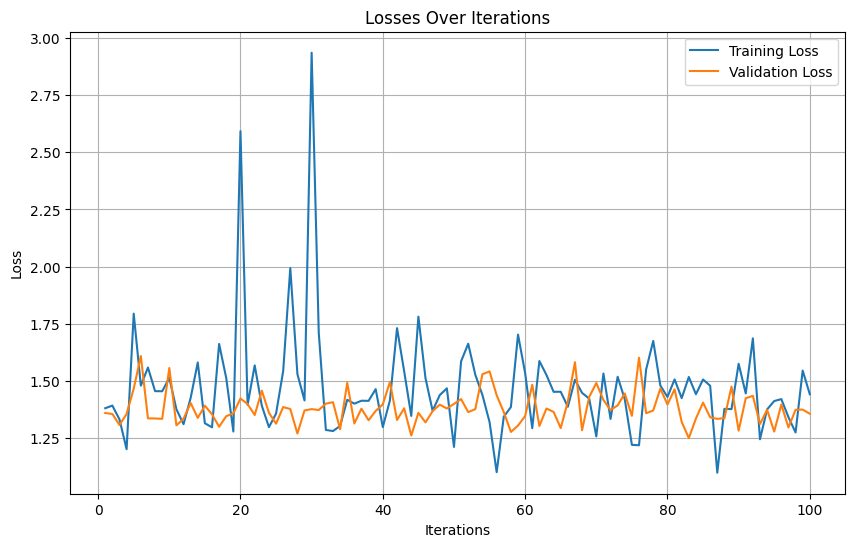

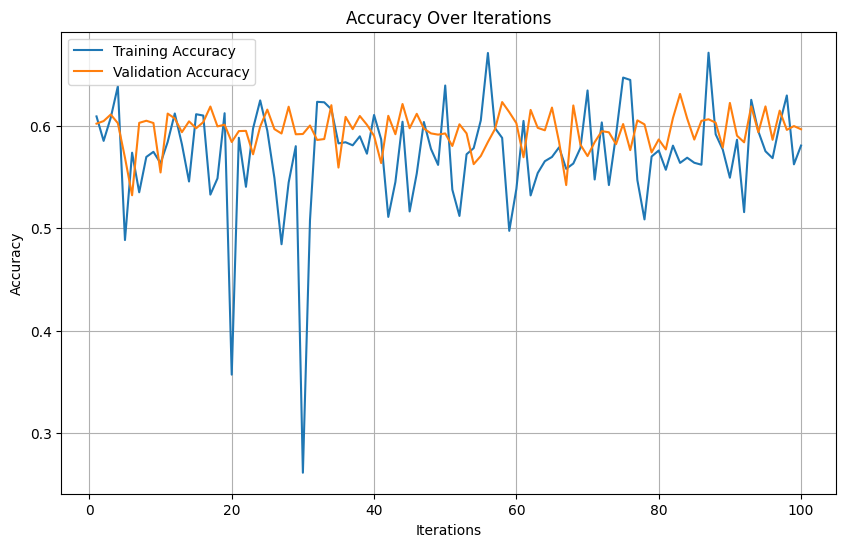

In [11]:
def plot_graphs():
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Losses Over Iterations')
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Over Iterations')
    plt.grid(True)
    plt.show()

plot_graphs()

In [ ]:
prompt = 'Hello! Can you see me?'
context = torch.tensor(encode(prompt), dtype=torch.long, device=device)
generated_chars = decode(m.generate(context.unsqueeze(0), max_new_tokens=100)[0].tolist())
print(generated_chars)